# Touchdown Forecast: NCAA Football
### Kenneth Woodard

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

### Data Preproccessing/Organization

Note: Only FBS teams matter aka these 131 teams. 
We do not care about FCS data due to the massive gap in talent between these divisions in the sport. Most non-college fans didn't even know there were multiple divisions in Division 1 College Football. Comparing FCS to FBS is like comparing apples to bowling balls. Therefore, all games involving an FCS team have also been removed. That data would only hurt performance. 

In [149]:
# all data has been pulled from collegefootballdata.com
# read in team list and extract only school, color, and conference
df = pd.read_csv("TEAMS.csv")
df_teams = df[["id", "school", "conference", "color"]]
df_teams.sort_values(by=["school"], inplace=True)
print(df_teams)

       id             school      conference    color
0    2005          Air Force   Mountain West  #004a7b
1    2006              Akron    Mid-American  #00285e
2     333            Alabama             SEC  #690014
3    2026  Appalachian State        Sun Belt  #000000
4      12            Arizona          Pac-12  #002449
..    ...                ...             ...      ...
128   277      West Virginia          Big 12  #FFC600
126    98   Western Kentucky  Conference USA  #F32026
127  2711   Western Michigan    Mid-American  #532e1f
129   275          Wisconsin         Big Ten  #A00001
130  2751            Wyoming   Mountain West  #533B22

[131 rows x 4 columns]


In [150]:
# read in coach data
# extract school of coach and their rating from the "simple rating system"
df = pd.read_csv("COACH_RECORD.csv")
df_coach = df[["school", "srs"]]

# dropping this row bc they had Univ. of South FL in here twice
df_coach = df_coach.drop(df.index[110])
df_coach.sort_values(by=["school"], inplace=True)
print(df_coach)

                school   srs
17           Air Force   2.3
94               Akron -14.2
106            Alabama  19.6
24   Appalachian State  -0.6
46             Arizona  -1.7
..                 ...   ...
16       West Virginia   5.0
64    Western Kentucky  -1.8
81    Western Michigan -13.9
22           Wisconsin   4.6
10             Wyoming -10.7

[131 rows x 2 columns]


In [151]:
# read in team talent composite data
# these are ratings on each teams based on
# an average of different recruiting sights
df_talent = pd.read_csv("TEAM_TALENT_COMP.csv")
df_talent = df_talent[["school", "talent"]]
df_talent.sort_values(by=["school"], inplace=True)

# remove all FCS/lower division teams, and print them
print("FCS teams removed:")
fcs = list(set(df_teams['school']).symmetric_difference(set(df_talent['school'])))
print(fcs)

filter = df_talent["school"].isin(df_teams["school"])
df_talent = df_talent[filter]
print()
print("FBS Team Talent Data")

print(df_talent)

FCS teams removed:
['Stony Brook', 'McNeese', 'Wagner', 'Grambling', 'Alabama A&M', 'Bryant', 'Campbell', 'Princeton', 'Stephen F. Austin', 'Duquesne', 'Eastern Washington', 'Lamar', 'Villanova', 'South Carolina State', 'Illinois State', 'South Dakota', 'Mercer', 'New Hampshire', 'North Carolina Central', 'East Tennessee State', 'Montana', 'Jacksonville State', 'William & Mary', 'Northwestern State', 'Arkansas-Pine Bluff', 'Southeast Missouri State', 'North Dakota State', 'Central Arkansas', 'Rhode Island', 'Maine', 'The Citadel', 'Gardner-Webb', 'North Alabama', 'Samford', 'Northern Arizona', 'UT Martin', 'Portland State', 'North Carolina A&T', 'Weber State', 'Richmond', 'Kennesaw State', 'Nicholls', 'Southern Utah', 'Albany', 'Furman', 'Northern Iowa', 'Sam Houston State', 'South Dakota State', 'Colgate', 'Houston Christian', 'Delaware', 'Montana State', 'Jacksonville', 'Charleston Southern', 'Missouri State', 'Murray State', 'Western Carolina', 'Central Connecticut', 'Southern Illin

In [152]:
# now we can combine the previous three datasets into one
# that consists of school, conference, coach rating, and talent rating
# We will use TEAM_DATA to pull up the actual team's data when we test specific 
# matchups with the model
d1 = pd.merge(df_teams, df_coach, on ='school')
team_data = pd.merge(d1, df_talent, on ='school')
print(team_data)

       id             school      conference    color   srs   talent
0    2005          Air Force   Mountain West  #004a7b   2.3     0.00
1    2006              Akron    Mid-American  #00285e -14.2   456.15
2     333            Alabama             SEC  #690014  19.6  1016.79
3    2026  Appalachian State        Sun Belt  #000000  -0.6   456.66
4      12            Arizona          Pac-12  #002449  -1.7   652.06
..    ...                ...             ...      ...   ...      ...
126   277      West Virginia          Big 12  #FFC600   5.0   662.57
127    98   Western Kentucky  Conference USA  #F32026  -1.8   495.64
128  2711   Western Michigan    Mid-American  #532e1f -13.9   449.89
129   275          Wisconsin         Big Ten  #A00001   4.6   744.44
130  2751            Wyoming   Mountain West  #533B22 -10.7   292.03

[131 rows x 6 columns]


## Average Talent & Head Coach Rating Per FBS Conference

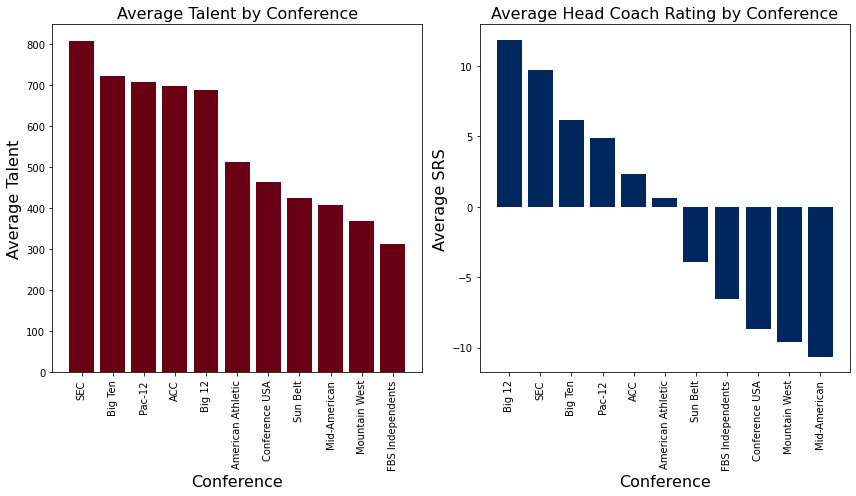

In [153]:
# Calculate the average talent and srs for each conference
avg_talent = team_data.groupby("conference")["talent"].mean().sort_values(ascending=False)
avg_srs = team_data.groupby("conference")["srs"].mean().sort_values(ascending=False)

# Create the bar graphs for the average talent and srs for each conference
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# Bar graph for average talent
ax1.bar(avg_talent.index, avg_talent.values, color=team_data["color"].iloc[2])
ax1.set_title("Average Talent by Conference", fontsize = 16)
ax1.set_xlabel("Conference", fontsize = 16)
ax1.set_ylabel("Average Talent", fontsize = 16)

# Bar graph for average srs
ax2.bar(avg_srs.index, avg_srs.values, color=team_data["color"].iloc[1])
ax2.set_title("Average Head Coach Rating by Conference", fontsize = 16)
ax2.set_xlabel("Conference", fontsize = 16)
ax2.set_ylabel("Average SRS", fontsize = 16)

# rotate x tick labels
ax1.tick_params(axis="x", rotation=90)
ax2.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

## Scatter of Roster Talent to Head Coach Rating

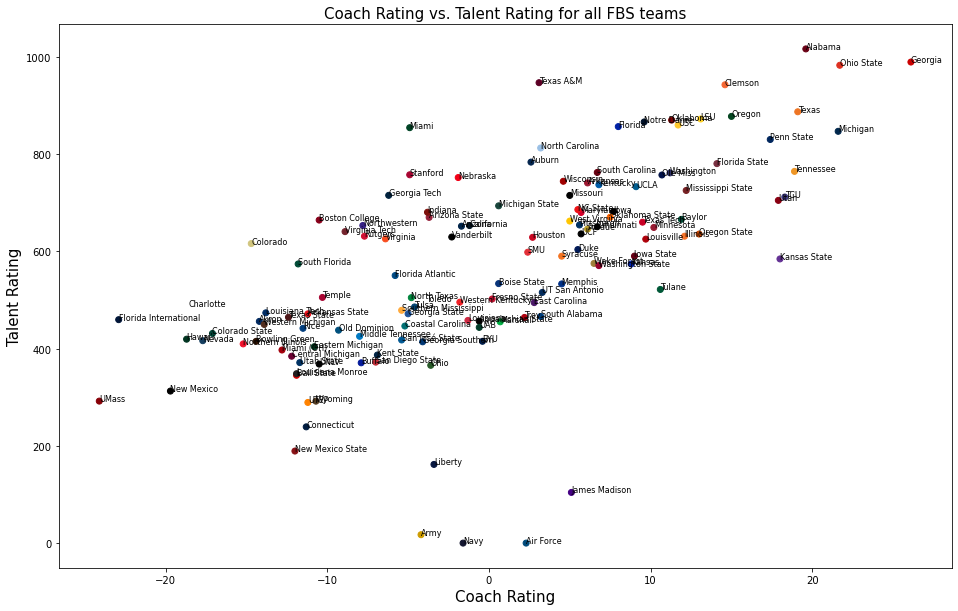

In [154]:
# scatter plot that represents teams based on
# talent and coaching acumen

fig = plt.figure(figsize=(16, 10))
plt.scatter(team_data["srs"], team_data["talent"], c = team_data["color"])

# Add labels for each point
for i, txt in enumerate(team_data["school"]):
    plt.text(team_data["srs"][i], team_data["talent"][i], txt, fontsize=8)
    
plt.xlabel("Coach Rating", fontsize=15)
plt.ylabel("Talent Rating", fontsize=15)
plt.title("Coach Rating vs. Talent Rating for all FBS teams", fontsize=15)
plt.show()

In [155]:
# read in final results from 2022 regular season
# remove all FCS data, including FBS vs. FCS matchups
# remove games that have not happened yet
# remove irrelevant columns 
df_results = pd.read_csv("FINAL_RESULTS.csv")
df_spreads = pd.read_csv("spreads.csv")
df_spreads = df_spreads.loc[(df_spreads["lineProvider"] == "consensus")]
df_s = df_spreads[["id", "spread"]]
r2d2 = pd.merge(df_results, df_s, on ="id")
df_results = r2d2

df_results = df_results.loc[(df_results["completed"] == True) & (df_results["home_division"] == "fbs") & (df_results["away_division"] == "fbs")]
df_results.drop(['id', 'excitement_index', 'home_team', 'away_team', 'away_post_win_prob', 'away_pregame_elo', 'away_postgame_elo', 'away_conference','home_postgame_elo', 'home_post_win_prob', 'home_pregame_elo', 'away_division','home_conference', 'home_division', 'season', 'season_type', 'conference_game', 'start_date', 'attendance', 'venue_id', 'venue', 'highlights', 'notes', 'start_time_tbd', 'completed'], axis=1, inplace=True)
df_results["margin"] = df_results["home_points"] - df_results["away_points"]
df_results.drop(['home_line_scores[0]', 'home_line_scores[1]', 'home_line_scores[2]', 'home_line_scores[3]'], axis=1, inplace=True)
df_results.drop(['away_line_scores[0]', 'away_line_scores[1]', 'away_line_scores[2]', 'away_line_scores[3]'], axis=1, inplace=True)
df_results = df_results.dropna()

# add talent and coach rating for the home and away teams
home_tal = []
away_tal = []
home_c = []
away_c = []

i = 0
for index, row in df_results.iterrows():
    i = row['home_id']
    team = team_data.loc[team_data["id"] == i]
    t = float(team["talent"])
    c = float(team["srs"])
    home_tal.append(t)
    home_c.append(c)
    i = row['away_id']
    team = team_data.loc[team_data["id"] == i]
    t = float(team["talent"])
    c = float(team["srs"])
    away_tal.append(t)
    away_c.append(c)

    
df_results["home_talent"] = home_tal
df_results["away_talent"] = away_tal
df_results["home_coach"] = home_c
df_results["away_coach"] = away_c
df_results["home_covers"] = (df_results["spread"] + df_results["margin"] > 0).astype(bool)
df_results["margin"] = df_results["margin"] * -1
df_results.drop(["home_points", "away_points"], axis=1)
print(df_results)

      week  neutral_site  home_id  home_points  away_id  away_points  spread  \
1        1          True       77         31.0      158         28.0    12.5   
4        1         False      328         31.0       41         20.0   -24.0   
5        1         False      356         38.0     2751          6.0   -14.0   
10       1         False     2638         13.0      249         31.0     1.5   
11       1         False      166         12.0     2440         23.0     7.0   
...    ...           ...      ...          ...      ...          ...     ...   
1195    14          True       61         50.0       99         30.0   -17.5   
1196    14         False       68         16.0      278         28.0    -3.0   
1197    14         False     2655         45.0     2116         28.0    -3.5   
1198    14          True      153         10.0      228         39.0     7.5   
1199    14          True      130         43.0     2509         22.0   -16.0   

      margin  home_talent  away_talent 

## Scatterplot of average home team margin of victory week-to-week

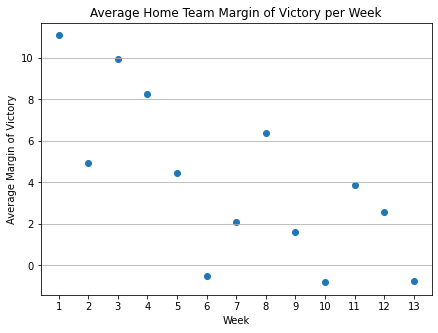

In [156]:

m = [] # average margin of victory for home team
w = [1,2,3,4,5,6,7,8,9,10,11,12,13] # weeks

for n in range(1,14):
    d = df_results.loc[df_results["week"] == n]
    total = -1*d["margin"]
    m.append(np.average(total))
    
fig = plt.figure(figsize=(7, 5)) 
plt.scatter(w, m)
plt.title("Average Home Team Margin of Victory per Week")
plt.xlabel("Week")
plt.xticks(w)
plt.ylabel("Average Margin of Victory")
plt.grid(axis='y')
plt.show()

# as you can see, the away team has handled playing on the road
# better on average per week

### How frequent are neutral site games in the Division 1 FBS Football?

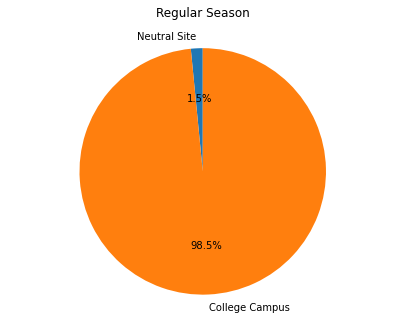

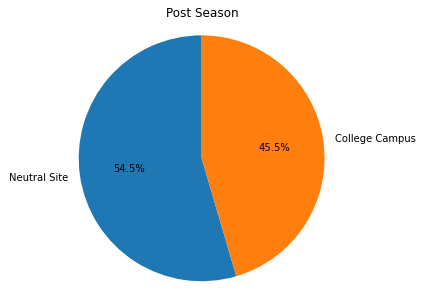

In [157]:
regular_season_data = df_results.loc[(df_results['week'] <= 13)]
neutral_site_data = regular_season_data.loc[regular_season_data['neutral_site'] == True]
non_neutral_site_data = regular_season_data.loc[regular_season_data['neutral_site'] == False]
num_neutral_site_games = len(neutral_site_data)
num_non_neutral_site_games = len(non_neutral_site_data)
total_games = num_neutral_site_games + num_non_neutral_site_games
neutral_site_percentage = num_neutral_site_games / total_games * 100
non_neutral_site_percentage = num_non_neutral_site_games / total_games * 100
labels = ['Neutral Site', 'College Campus']
sizes = [neutral_site_percentage, non_neutral_site_percentage]
fig = plt.figure(figsize=(7, 5)) 
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Regular Season", y=1.05)
plt.axis('equal')
plt.show()

post_season_data = df_results.loc[(df_results['week'] > 13)]
neutral_site_data = post_season_data.loc[post_season_data['neutral_site'] == True]
non_neutral_site_data = post_season_data.loc[post_season_data['neutral_site'] == False]
num_neutral_site_games = len(neutral_site_data)
num_non_neutral_site_games = len(non_neutral_site_data)
total_games = num_neutral_site_games + num_non_neutral_site_games
neutral_site_percentage = num_neutral_site_games / total_games * 100
non_neutral_site_percentage = num_non_neutral_site_games / total_games * 100
labels = ['Neutral Site', 'College Campus']
sizes = [neutral_site_percentage, non_neutral_site_percentage]
fig = plt.figure(figsize=(7, 5)) 
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Post Season")
plt.axis('equal')
plt.show()

## I wish we always played on college campuses. Much better atmosphere then a sterile, lifeless NFL stadium.
## Best regular season in all of sports. 

## Let's test the model with different parameters

In [158]:
# I tested every week from week 3 to week 13
# Obviously it did terrible for week 3, not enough data

from sklearn.metrics import mean_absolute_error
df_r = df_results[["week", "neutral_site", "spread", "home_talent", "away_talent", "home_coach", "away_coach"]]
df_y = df_results[["margin", "home_covers"]]
y = df_y["margin"].to_numpy().flatten()
X = df_r.to_numpy()

# Filter data for weeks 1-n for training and week n+1 for testing
X_train = X[df_r["week"] <= 5]
y_train = y[df_r["week"] <= 5]
X_test = X[df_r["week"] == 6]
y_test = y[df_r["week"] == 6]

splits = KFold(n_splits=3)
neuron_arr = [50, 500, 1000, 2000]
learn_arr = [.01, .10, 1.0]
acc_arr = []  # within 3 PTs? 
cov_acc = []  # does it hit the spread?

for n in neuron_arr:
    for l in learn_arr:
        correct_pred_count = 0   # field goal difference
        total_pred_count = 0
        correct_pred_count_1 = 0 # point spread bet hits
        total_pred_count_1 = 0
        
        for train_index, val_index in splits.split(X_train):
            reg = MLPRegressor(hidden_layer_sizes=(n), max_iter=500, random_state=42, learning_rate_init=l)
            
            X_subtrain = X_train[train_index]
            X_val = X_train[val_index]
            y_subtrain = y_train[train_index]
            y_val = y_train[val_index]
            reg.fit(X_subtrain, y_subtrain)
            y_predict = reg.predict(X_val)
            y_pred_margin = (y_predict)
            
            # field goal
            for i in range(len(y_pred_margin)):
                total_pred_count += 1
                if abs(y_pred_margin[i] - y_val[i]) <= 3:
                    correct_pred_count += 1
                    
            # spread
            for i in range(len(y_pred_margin)):
                total_pred_count_1 += 1
                if (y_val[i] < X_val[i][2] and y_pred_margin[i] < X_val[i][2]) or (y_val[i] > X_val[i][2] and y_pred_margin[i] > X_val[i][2]):
                    correct_pred_count_1 += 1
                elif (y_val[i] == X_val[i][2] == y_pred_margin[i]):
                    total_pred_count_1 -= 1
                    
        
        accuracy = correct_pred_count / total_pred_count
        accuracy_1 = correct_pred_count_1 / total_pred_count_1
        print("N=" + str(n))
        print("L=" + str(l))
        print("Field Goal Diff Acc=" + str(accuracy))
        print("Spread Bet Hits Acc=" + str(accuracy_1))
        acc_arr.append(accuracy)
        cov_acc.append(accuracy_1)


N=50
L=0.01
Field Goal Diff Acc=0.18631178707224336
Spread Bet Hits Acc=0.6349809885931559
N=50
L=0.1
Field Goal Diff Acc=0.1634980988593156
Spread Bet Hits Acc=0.532319391634981
N=50
L=1.0
Field Goal Diff Acc=0.13688212927756654
Spread Bet Hits Acc=0.5057034220532319
N=500
L=0.01
Field Goal Diff Acc=0.030418250950570342
Spread Bet Hits Acc=0.4866920152091255
N=500
L=0.1
Field Goal Diff Acc=0.06844106463878327
Spread Bet Hits Acc=0.4790874524714829
N=500
L=1.0
Field Goal Diff Acc=0.053231939163498096
Spread Bet Hits Acc=0.5209125475285171
N=1000
L=0.01
Field Goal Diff Acc=0.23193916349809887
Spread Bet Hits Acc=0.6121673003802282
N=1000
L=0.1
Field Goal Diff Acc=0.011406844106463879
Spread Bet Hits Acc=0.4752851711026616
N=1000
L=1.0
Field Goal Diff Acc=0.049429657794676805
Spread Bet Hits Acc=0.5019011406844106
N=2000
L=0.01
Field Goal Diff Acc=0.11406844106463879
Spread Bet Hits Acc=0.5551330798479087
N=2000
L=0.1
Field Goal Diff Acc=0.07604562737642585
Spread Bet Hits Acc=0.55133079

## Heatmap the data

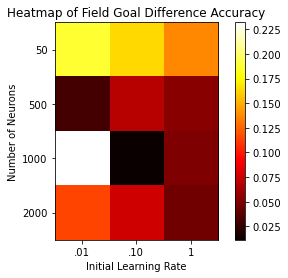

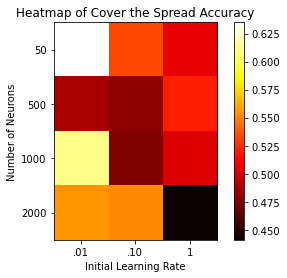

In [159]:
# Heatmap time
y_labels = ["50","500","1000", "2000"]
x_labels = [".01", ".10", "1"]

# Field Goal
accuracy = np.array(acc_arr)
acc_2D = accuracy.reshape(4,3)
plt.imshow(acc_2D, cmap='hot', interpolation='nearest')
plt.title('Heatmap of Field Goal Difference Accuracy')
plt.xticks(range(0,len(x_labels)), x_labels)
plt.yticks(range(0,len(y_labels)), y_labels)
plt.colorbar()
plt.xlabel("Initial Learning Rate")
plt.ylabel("Number of Neurons")
plt.show()

# Spread 
accuracy = np.array(cov_acc)
acc_2D = accuracy.reshape(4,3)
plt.imshow(acc_2D, cmap='hot', interpolation='nearest')
plt.title('Heatmap of Cover the Spread Accuracy')
plt.xticks(range(0,len(x_labels)), x_labels)
plt.yticks(range(0,len(y_labels)), y_labels)
plt.colorbar()
plt.xlabel("Initial Learning Rate")
plt.ylabel("Number of Neurons")
plt.show()

# 0.01 learning rate is the best option
# 50 is the best across the weeks

## Test now for multiple layers

In [166]:
# now lets test whether we want more layers
acc_arr = []  # within 3 PTs? 
cov_acc = []  # does it hit the spread?
combos = [(50,35), (50,65,35), (50,7), (50,10)]

for c in combos:
        correct_pred_count = 0   # field goal difference
        total_pred_count = 0
        correct_pred_count_1 = 0 # point spread bet hits
        total_pred_count_1 = 0
        
        for train_index, val_index in splits.split(X_train):
            reg = MLPRegressor(hidden_layer_sizes=(c), max_iter=500, random_state=42, learning_rate_init=0.01)
            
            X_subtrain = X_train[train_index]
            X_val = X_train[val_index]
            y_subtrain = y_train[train_index]
            y_val = y_train[val_index]
            reg.fit(X_subtrain, y_subtrain)
            y_predict = reg.predict(X_val)
            y_pred_margin = (y_predict)
            
            # field goal
            for i in range(len(y_pred_margin)):
                total_pred_count += 1
                if abs(y_pred_margin[i] - y_val[i]) <= 3:
                    correct_pred_count += 1
                    
            # spread
            for i in range(len(y_pred_margin)):
                total_pred_count_1 += 1
                if (y_val[i] < X_val[i][2] and y_pred_margin[i] < X_val[i][2]) or (y_val[i] > X_val[i][2] and y_pred_margin[i] > X_val[i][2]):
                    correct_pred_count_1 += 1
                elif (y_val[i] == X_val[i][2] == y_pred_margin[i]):
                    total_pred_count_1 -= 1                  
        
        accuracy = correct_pred_count / total_pred_count
        accuracy_1 = correct_pred_count_1 / total_pred_count_1
        print("N=" + str(c))
        print("Field Goal Diff Acc=" + str(accuracy))
        print("Spread Bet Hits Acc=" + str(accuracy_1) + "\n")
        acc_arr.append(accuracy)
        cov_acc.append(accuracy_1)

        
# 50, 35 combo is the best combination for each accuracy!

N=(50, 35)
Field Goal Diff Acc=0.20987654320987653
Spread Bet Hits Acc=0.6280864197530864

N=(50, 65, 35)
Field Goal Diff Acc=0.16820987654320987
Spread Bet Hits Acc=0.6342592592592593

N=(50, 7)
Field Goal Diff Acc=0.1558641975308642
Spread Bet Hits Acc=0.5709876543209876

N=(50, 10)
Field Goal Diff Acc=0.13734567901234568
Spread Bet Hits Acc=0.5324074074074074



In [161]:
def predict_game_score(week, home_school, away_school, spread, neutral_site):
    # Get the home and away team talent and SRS ratings
    home = team_data.loc[team_data["school"] == home_school]
    away = team_data.loc[team_data["school"] == away_school]
    home_talent = float(home["talent"])
    away_talent = float(away["talent"])
    home_srs = float(home["srs"])
    away_srs = float(away["srs"])
    
    # Load the game data and add the home and away team ratings
    game_data = pd.DataFrame({
        "week": [week],
        "neutral_site": [neutral_site],
        "spread": [spread],
        "home_talent": [home_talent],
        "away_talent": [away_talent],
        "home_coach": [home_srs],
        "away_coach": [away_srs]
    })
    
    # Train the model on prior weeks data
    X_train = X[df_r["week"] < week]
    y_train = y[df_r["week"] < week]
    model = MLPRegressor(hidden_layer_sizes=(50,35), max_iter=500, random_state=42, learning_rate_init=0.01)
    model.fit(X_train, y_train)
    
    # Use the trained model to predict the game score
    prediction = model.predict(game_data)
    model_spread = prediction[0]
    
    # Format the prediction string
    if prediction[0] < 0:
        model_spread = abs(prediction[0])
        prediction_str = "{}(+{}) at {}".format(away_school, round(model_spread, 2), home_school)
    else:
        prediction_str = "{}(-{}) at {}".format(away_school, round(model_spread, 2), home_school)
    
    return prediction_str

## SEC 2022 Picks

In [169]:
### format: predict_game_score(week, home_school, away_school, spread {for home team}, neutral_site)

# Context: in the first example the spread is +8.5 because the away team, Arkansas is favored
# if the home team were favored it would be negative like the Florida-Kentucky game

print(" -------- Score: (spreads hit / total games) -------")

print("Week 2")
print(predict_game_score(2, "South Carolina", "Arkansas", 8.5, False))
print(predict_game_score(2, "Florida", "Kentucky", -6, False))
print()

print("Week 3")
print(predict_game_score(3, "South Carolina", "Georgia", 25.5, False))
print(predict_game_score(3, "LSU", "Mississippi State", 3.0, False))
print()

print("Week 4")
print(predict_game_score(4, "Tennessee", "Florida", -11, False))
print(predict_game_score(4, "Alabama", "Vanderbilt", -40.5, False))
print(predict_game_score(4, "Texas A&M", "Arkansas", -1.5, True))
print(predict_game_score(4, "Auburn", "Missouri", -7.5, False))
print()

print("Week 5")
print(predict_game_score(5, "Missouri", "Georgia", -30.5, False))
print(predict_game_score(5, "Ole Miss", "Kentucky", -6.5, False))
print(predict_game_score(5, "Arkansas", "Alabama", 17, False))
print(predict_game_score(5, "Auburn", "LSU", 8, False))
print(predict_game_score(5, "Mississippi State", "Texas A&M", -4, False))
print()

print("Week 6")
print(predict_game_score(6, "LSU", "Tennessee", 2.5, False))
print(predict_game_score(6, "Kentucky", "South Carolina", -4.5, False))
print(predict_game_score(6, "Vanderbilt", "Ole Miss", 17, False))
print(predict_game_score(6, "Georgia", "Auburn", -27.5, False))
print(predict_game_score(6, "Mississippi State", "Arkansas", -8.5, False))
print(predict_game_score(6, "Florida", "Missouri", -10.5, False))
print(predict_game_score(6, "Alabama", "Texas A&M", -24, False))
print()

print("Week 7")
print(predict_game_score(7, "Tennessee", "Alabama", 9, False))
print(predict_game_score(7, "Georgia", "Vanderbilt", -37.5, False))
print(predict_game_score(7, "Kentucky", "Mississippi State", 3.5, False))
print(predict_game_score(7, "Ole Miss", "Auburn", -15.5, False))
print(predict_game_score(7, "Florida", "LSU", -2, False))
print()

print("Week 8")
print(predict_game_score(8, "Missouri", "Vanderbilt", -14, False))
print(predict_game_score(8, "LSU", "Ole Miss", 0, False))
print(predict_game_score(8, "Alabama", "Mississippi State", -21, False))
print(predict_game_score(8, "South Carolina", "Texas A&M", 3, False))
print()

print("Week 9")
print(predict_game_score(9, "Tennessee", "Kentucky", -10.5, False))
print(predict_game_score(9, "Georgia", "Florida", -23, True))
print(predict_game_score(9, "Texas A&M", "Ole Miss", 3, False))  # push, Ole Miss won by 3
print(predict_game_score(9, "Auburn", "Arkansas", 4, False))
print(predict_game_score(9, "South Carolina", "Missouri", -3.5, False))
print()

print("Week 10")
print(predict_game_score(10, "Texas A&M", "Florida", -1.5, False))
print(predict_game_score(10, "Georgia", "Tennessee", -9.5, False))
print(predict_game_score(10, "Vanderbilt", "South Carolina", 6.5, False))
print(predict_game_score(10, "Missouri", "Kentucky", -1, False))
print(predict_game_score(10, "LSU", "Alabama", 13.5, False))
print(predict_game_score(10, "Mississippi State", "Auburn", -12.5, False))
print()


print("Week 11")
print(predict_game_score(11, "Mississippi State", "Georgia", 16.5, False))
print(predict_game_score(11, "Florida", "South Carolina", -8, False))
print(predict_game_score(11, "Kentucky", "Vanderbilt", -17, False))
print(predict_game_score(11, "Ole Miss", "Alabama", 11, False))
print(predict_game_score(11, "Arkansas", "LSU", 3.5, False))
print(predict_game_score(11, "Tennessee", "Missouri", -19, False))
print(predict_game_score(11, "Auburn", "Texas A&M", -19, False))
print()

print("Week 12")
print(predict_game_score(12, "South Carolina", "Tennessee", 22.5, False))
print(predict_game_score(12, "Kentucky", "Georgia", 22.5, False))
print(predict_game_score(12, "Vanderbilt", "Florida", 14, False))
print(predict_game_score(12, "Arkansas", "Ole Miss", 0, False))
print()

print("Week 13")
print(predict_game_score(13, "Vanderbilt", "Tennessee", 14, False))
print(predict_game_score(13, "Auburn", "Alabama", 22, False))
print(predict_game_score(13, "Ole Miss", "Mississippi State", -2.5, False))
print(predict_game_score(13, "Texas A&M", "LSU", 10, False))
print(predict_game_score(13, "Missouri", "Arkansas", 3.5, False))
print()

 -------- Score: (spreads hit / total games) -------
Week 2
Arkansas(+20.9) at South Carolina
Kentucky(+28.51) at Florida

Week 3
Georgia(-24.14) at South Carolina
Mississippi State(+0.52) at LSU

Week 4
Florida(-20.48) at Tennessee
Vanderbilt(+12.39) at Alabama
Arkansas(-2.03) at Texas A&M
Missouri(-8.14) at Auburn

Week 5
Georgia(-38.54) at Missouri
Kentucky(-16.86) at Ole Miss
Alabama(-45.72) at Arkansas
LSU(-34.68) at Auburn
Texas A&M(-27.38) at Mississippi State

Week 6
Tennessee(-5.9) at LSU
South Carolina(+4.64) at Kentucky
Ole Miss(-13.03) at Vanderbilt
Auburn(+30.2) at Georgia
Arkansas(+10.96) at Mississippi State
Missouri(+7.18) at Florida
Texas A&M(+25.57) at Alabama

Week 7
Alabama(-7.25) at Tennessee
Vanderbilt(+33.65) at Georgia
Mississippi State(-7.19) at Kentucky
Auburn(+9.94) at Ole Miss
LSU(-6.03) at Florida

Week 8
Vanderbilt(+10.52) at Missouri
Ole Miss(+1.62) at LSU
Mississippi State(+9.8) at Alabama
Texas A&M(+0.22) at South Carolina

Week 9
Kentucky(+13.9) at Ten

## RIVALRY WEEK PREDICTIONS

In [163]:
# below im testing the model for each game in rivalry week
# hence, train data is weeks 1-12
# I was pleasantly surprised with these results
# Each Prediction was reasonable and most of them
# were on the correct side of the spread. 

df_r = df_results[["week", "neutral_site", "spread", "home_talent", "away_talent", "home_coach", "away_coach"]]
df_y = df_results[["margin", "home_covers"]]
y = df_y["margin"].to_numpy().flatten()
X = df_r.to_numpy()

# Rivalry Week (Week 13)
X_train = X[df_r["week"] <= 12]
y_train = y[df_r["week"] <= 12]

# Create the MLPRegressor model
model = MLPRegressor(hidden_layer_sizes=(50,35), max_iter=500, random_state=42, learning_rate_init=0.01)

# Train the model
model.fit(X_train, y_train)

print(" ------- NOTE ------- ")
print("If prediction is positive, that indicates a win for the away team.")
print("If negative, the home team is picked to win. Also, No SEC-SEC Matchups below")
print("\n")
print("Rivalry Week\n")

# FSU-UF
home = team_data.loc[team_data["school"] == "Florida State"]
away = team_data.loc[team_data["school"] == "Florida"]
fsu_uf = [[13, False, -9.5, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(fsu_uf)
print("Model's spread for Florida @ FSU: ", round(float(prediction), 2))

# GT-UGA
home = team_data.loc[team_data["school"] == "Georgia"]
away = team_data.loc[team_data["school"] == "Georgia Tech"]
gt_uga = [[13, False, -36.5, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(gt_uga)
print("Model's spread for GT @ Georgia: ", round(float(prediction), 2))

# OSU-MICH
home = team_data.loc[team_data["school"] == "Ohio State"]
away = team_data.loc[team_data["school"] == "Michigan"]
osu_mich = [[13, False, -36.5, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(osu_mich)
print("Model's spread for Michigan @ Ohio State: ", round(float(prediction), 2))

# UCLA-CAL
home = team_data.loc[team_data["school"] == "California"]
away = team_data.loc[team_data["school"] == "UCLA"]
matchup = [[13, False, 11.5, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for UCLA @ Cal: ", round(float(prediction), 2))

# Cincy-Tulane
home = team_data.loc[team_data["school"] == "Cincinnati"]
away = team_data.loc[team_data["school"] == "Tulane"]
matchup = [[13, False, 1.0, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Tulane @ Cincinnati: ", round(float(prediction), 2))

# Baylor-Texas
home = team_data.loc[team_data["school"] == "Texas"]
away = team_data.loc[team_data["school"] == "Baylor"]
matchup = [[13, False, -10, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Baylor @ Texas: ", round(float(prediction), 2))

# Arizona-ASU
home = team_data.loc[team_data["school"] == "Arizona"]
away = team_data.loc[team_data["school"] == "Arizona State"]
matchup = [[13, False, -4, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for ASU @ Arizona: ", round(float(prediction), 2))

# Iowa-Nebraska
home = team_data.loc[team_data["school"] == "Iowa"]
away = team_data.loc[team_data["school"] == "Nebraska"]
matchup = [[13, False, -10.5, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Nebraska @ Iowa: ", round(float(prediction), 2))

# Oregon-Oregon State
home = team_data.loc[team_data["school"] == "Oregon State"]
away = team_data.loc[team_data["school"] == "Oregon"]
matchup = [[13, False, -1, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Oregon @ Oregon State: ", round(float(prediction), 2))

# Indiana-Purdue
home = team_data.loc[team_data["school"] == "Indiana"]
away = team_data.loc[team_data["school"] == "Purdue"]
matchup = [[13, False, 10, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Purdue @ Indiana: ", round(float(prediction), 2))

# SMU-Memphis
home = team_data.loc[team_data["school"] == "SMU"]
away = team_data.loc[team_data["school"] == "Memphis"]
matchup = [[13, False, -4.5, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Memphis @ SMU: ", round(float(prediction), 2))

# Clem-SCAR
home = team_data.loc[team_data["school"] == "Clemson"]
away = team_data.loc[team_data["school"] == "South Carolina"]
matchup = [[13, False, -14.0, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for South Carolina @ Clemson: ", round(float(prediction), 2))

# Rutgers-Maryland
home = team_data.loc[team_data["school"] == "Maryland"]
away = team_data.loc[team_data["school"] == "Rutgers"]
matchup = [[13, False, -4.5, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Rutgers @ Maryland: ", round(float(prediction), 2))

# Kentucky-Louisville
home = team_data.loc[team_data["school"] == "Kentucky"]
away = team_data.loc[team_data["school"] == "Louisville"]
matchup = [[13, False, -3.5, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Louisville @ Kentucky: ", round(float(prediction), 2))

# Duke-Wake
home = team_data.loc[team_data["school"] == "Duke"]
away = team_data.loc[team_data["school"] == "Wake Forest"]
matchup = [[13, False, 3.0, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Wake Forest @ Duke: ", round(float(prediction), 2))

# Akron-NIU
home = team_data.loc[team_data["school"] == "Northern Illinois"]
away = team_data.loc[team_data["school"] == "Akron"]
matchup = [[13, False, -9.5, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Akron @ Northern Illinois: ", round(float(prediction), 2))

# Southern Cal-Notre Dame
home = team_data.loc[team_data["school"] == "USC"]
away = team_data.loc[team_data["school"] == "Notre Dame"]
matchup = [[13, False, -4.5, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Notre Dame @ USC: ", round(float(prediction), 2))

# SDSU-Air Force
home = team_data.loc[team_data["school"] == "San Diego State"]
away = team_data.loc[team_data["school"] == "Air Force"]
matchup = [[13, False, 2.0, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Air Force @ San Diego State: ", round(float(prediction), 2))

# TCU-Iowa St.
home = team_data.loc[team_data["school"] == "TCU"]
away = team_data.loc[team_data["school"] == "Iowa State"]
matchup = [[13, False, -9.5, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Iowa State @ TCU: ", round(float(prediction), 2))

# Penn State-Mich State
home = team_data.loc[team_data["school"] == "Penn State"]
away = team_data.loc[team_data["school"] == "Michigan State"]
matchup = [[13, False, -19.0, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Michigan State @ Penn State: ", round(float(prediction), 2))

# Texas Tech-Oklahoma
home = team_data.loc[team_data["school"] == "Texas Tech"]
away = team_data.loc[team_data["school"] == "Oklahoma"]
matchup = [[13, False, 1.5, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Oklahoma @ Texas Tech: ", round(float(prediction), 2))

# Kansas State-Kansas
home = team_data.loc[team_data["school"] == "Kansas State"]
away = team_data.loc[team_data["school"] == "Kansas"]
matchup = [[13, False, -12.0, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Kansas @ Kansas State: ", round(float(prediction), 2))

# Washington State-Washington
home = team_data.loc[team_data["school"] == "Washington State"]
away = team_data.loc[team_data["school"] == "Washington"]
matchup = [[13, False, 2.5, float(home["talent"]), float(away["talent"]), float(home["srs"]), float(away["srs"])]]
prediction = model.predict(matchup)
print("Model's spread for Washington @ Washington State: ", round(float(prediction), 2))

 ------- NOTE ------- 
If prediction is positive, that indicates a win for the away team.
If negative, the home team is picked to win. Also, No SEC-SEC Matchups below


Rivalry Week

Model's spread for Florida @ FSU:  -16.29
Model's spread for GT @ Georgia:  -48.63
Model's spread for Michigan @ Ohio State:  -12.98
Model's spread for UCLA @ Cal:  4.17
Model's spread for Tulane @ Cincinnati:  -3.38
Model's spread for Baylor @ Texas:  -19.23
Model's spread for ASU @ Arizona:  -9.28
Model's spread for Nebraska @ Iowa:  -18.43
Model's spread for Oregon @ Oregon State:  -5.08
Model's spread for Purdue @ Indiana:  3.34
Model's spread for Memphis @ SMU:  -4.67
Model's spread for South Carolina @ Clemson:  -20.36
Model's spread for Rutgers @ Maryland:  -23.29
Model's spread for Louisville @ Kentucky:  -5.56
Model's spread for Wake Forest @ Duke:  -6.68
Model's spread for Akron @ Northern Illinois:  -1.26
Model's spread for Notre Dame @ USC:  -13.59
Model's spread for Air Force @ San Diego State

In [164]:

acc_arr = []  # within 3 PTs? 
cov_acc = []  # does it hit the spread?
    
for w in range(2,14):
    # Filter data for weeks 1-n for training and week n+1 for testing
    X_train = X[df_r["week"] < w]
    y_train = y[df_r["week"] < w]
    X_test = X[df_r["week"] == w]
    y_test = y[df_r["week"] == w]

    correct_pred_count = 0   # field goal difference
    total_pred_count = 0
    correct_pred_count_1 = 0 # point spread bet hits
    total_pred_count_1 = 0

    
    reg = MLPRegressor(hidden_layer_sizes=(50,35), max_iter=500, random_state=42, learning_rate_init=0.01)
    reg.fit(X_train, y_train)
    y_predict = reg.predict(X_val)
    y_pred_margin = (y_predict)

    for i in range(len(y_test)):
        y_val = y_test[i:i+1]
        X_val = X_test[i:i+1]
        y_predict = reg.predict(X_val)
        y_pred_margin = (y_predict)

        # field goal
        total_pred_count += 1
        if abs(y_pred_margin - y_val) <= 3:
            correct_pred_count += 1

        # spread
        total_pred_count_1 += 1
        if (y_val < X_val[0][2] and y_pred_margin < X_val[0][2]) or (y_val > X_val[0][2] and y_pred_margin > X_val[0][2]):
            correct_pred_count_1 += 1
        elif (y_val == X_val[0][2] == y_pred_margin):
            total_pred_count_1 -= 1



    accuracy = correct_pred_count / total_pred_count
    accuracy_1 = correct_pred_count_1 / total_pred_count_1
    print("Week " + str(w) + " results:")
    print("Field Goal Diff Acc=" + str(accuracy))
    print("Spread Bet Hits Acc=" + str(accuracy_1) + "\n")
    acc_arr.append(accuracy)
    cov_acc.append(accuracy_1)
    

Week 2 results:
Field Goal Diff Acc=0.10638297872340426
Spread Bet Hits Acc=0.3191489361702128

Week 3 results:
Field Goal Diff Acc=0.1
Spread Bet Hits Acc=0.66

Week 4 results:
Field Goal Diff Acc=0.11666666666666667
Spread Bet Hits Acc=0.48333333333333334

Week 5 results:
Field Goal Diff Acc=0.05357142857142857
Spread Bet Hits Acc=0.48214285714285715

Week 6 results:
Field Goal Diff Acc=0.12280701754385964
Spread Bet Hits Acc=0.5789473684210527

Week 7 results:
Field Goal Diff Acc=0.14
Spread Bet Hits Acc=0.58

Week 8 results:
Field Goal Diff Acc=0.1875
Spread Bet Hits Acc=0.5625

Week 9 results:
Field Goal Diff Acc=0.23404255319148937
Spread Bet Hits Acc=0.6595744680851063

Week 10 results:
Field Goal Diff Acc=0.16666666666666666
Spread Bet Hits Acc=0.6333333333333333

Week 11 results:
Field Goal Diff Acc=0.16129032258064516
Spread Bet Hits Acc=0.5967741935483871

Week 12 results:
Field Goal Diff Acc=0.14754098360655737
Spread Bet Hits Acc=0.6229508196721312

Week 13 results:
Field 

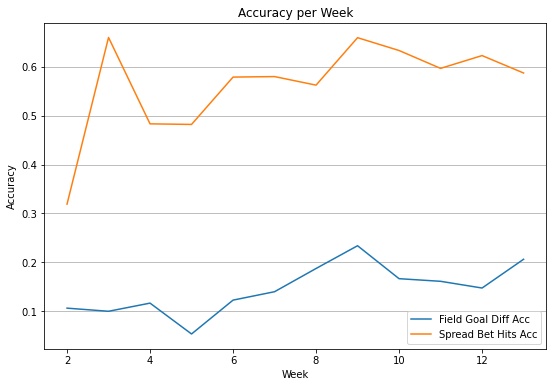

In [165]:
# create x-axis values for the plot
weeks = range(2, 14)

fig = plt.figure(figsize=(9, 6)) 

# plot the accuracy arrays
plt.plot(weeks, acc_arr, label='Field Goal Diff Acc')
plt.plot(weeks, cov_acc, label='Spread Bet Hits Acc')

# add title and axis labels
plt.title('Accuracy per Week')
plt.xlabel('Week')
plt.ylabel('Accuracy')
plt.grid(axis='y')

# add legend
plt.legend()

# show the plot
plt.show()

*Overall, I am satisfied with the model's performance. I wish I didn't have to pay to get the rest of the numbers that I want (cfbstats.com, aka the official dataset of the College Football Playoff). But, the data used here from CollegeFootballData.com should perform well enough for now. This will be one of the tools that I use next season, and I will try to add in more stats as I see fit. But for now, this is Touchdown Forecast 1.0. Factoring in prior seasons could be on the horizon, too.* 

# Make your own prediction!

In [168]:
# example (week, away_team, home_team, spread, neutral site)
# NOTE: Only weeks 2-14 work. Obviously, because there wouldn't be 
#       any data to predict on for week 1. Also, the spread is
#       positive if the away team is favored and negative if the 
#       home team is favored.

print(predict_game_score(13, "Vanderbilt", "Tennessee", 14, False))
print(predict_game_score(13, "Tennessee", "Vanderbilt", -14, False))

Tennessee(-16.58) at Vanderbilt
Vanderbilt(+33.78) at Tennessee


Notice how much the model values playing in Neyland Stadium. Ironically, we exceeded both of those numbers despite the fact that Tennessee played at Vanderbilt last season. 